# Analysis production and production loss - Brussels facility

In [1]:
# import some libraries to work with
import sys
sys.path.append('../packages')
from best_distribution import best_distribution as bd
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import statistics
import seaborn as sns
import scipy.stats
import numpy as np

##### retrieve the max sustainable rate from the master_data file

In [2]:
# get the max sustainable rate for Brussels
msr_df = pd.read_json('../data/master_data.json', typ='series')

In [3]:
# store the max sustainable rate for Brussels in a variable for later use
msr_brussel = msr_df['BRU msr']

##### retrieve the data for Brussels

In [4]:
# get the brussels data 
brussel = list()
for bestandsnaam in os.listdir('../data/daily_production/BRU/'):
    data = pd.read_json('../data/daily_production/BRU/'+bestandsnaam, typ='series')
    row = pd.Series(data)
    brussel.append(row)
    brussel_data= pd.DataFrame(brussel)

In [ ]:
# short check if this is the data that we can work with
brussel_data

In [6]:
# derrive a new variable from the panda dataframe
brussel_data_nulls = brussel_data

##### check for null values and where they orginate from

- observation 1: in brussels there is no #MV when there is no maintenance.
    - Meaning that when there is no maintenance, there is always production or production loss data.
- observation 2: we have no data if the maintenance is scheduled or not, we only notice that there is no data on days marked with maintenance 'yes'
    - we can determine for certain that in brussels there is no other recording than at hour 1 of the day there is no registration of maintenance on other timestamps

In [ ]:
# let's check the fields that are marked with maintenance 'yes'
for index, field in brussel_data_nulls.iterrows() :
    if field['maintenance']=="Yes":
        display(field)

In [8]:
# check if there is #MV values when maintenance is not 'yes'
for index, field in brussel_data_nulls.iterrows() :
    if  field['production']=='#MV' and field['maintenance']!="Yes":
        display(field)

In [9]:
# check if maintenance is set on other timestamps than 1
for index, field in brussel_data_nulls.iterrows() :
    if field['maintenance']=="Yes" and field['hour'] !=1:
        display(field)

##### first couple of conclusions:

- to make a prediction of the production capability of brussels  we can remove the rows where the record is marked with maintenance yes, since the task is to make a simulation, not to check for optimalisations in maintenance
- we can make the #MV values as 0 and plot them to see when the specific timings of maintenance occur (if there is time left)

In [10]:
# creating a new df with the dropped the #MV records 
brussel_data_wo_nulls = brussel_data.replace({"#MV": np.nan}).dropna()

In [ ]:
# check the dataframe
display(brussel_data_wo_nulls)

In [12]:
# let's set the objects to ints so we can use them for the graphs
brussel_data_wo_nulls['production'] = brussel_data_wo_nulls['production'].astype(int)
brussel_data_wo_nulls['prod_loss']  = brussel_data_wo_nulls['prod_loss'].astype(int)
# percentage is not used but we int it anyway just to do a describe of the dataframe
brussel_data_wo_nulls['prod_loss_perc']  = brussel_data_wo_nulls['prod_loss_perc'].astype(int)

In [13]:
# let's describe the dataset
brussel_data_wo_nulls.describe()

,hour,minute,prod_loss,prod_loss_perc,production
count,1736.0,1736.0,1736.000000,1736.000000,1736.000000
mean,1.0,0.0,430.288018,34.579493,813.711982
std,0.0,0.0,390.712496,31.413713,390.712496
min,1.0,0.0,51.000000,4.000000,0.000000
25%,1.0,0.0,196.750000,16.000000,860.750000
50%,1.0,0.0,270.500000,22.000000,973.500000
75%,1.0,0.0,383.250000,31.000000,1047.250000
max,1.0,0.0,1244.000000,100.000000,1193.000000


In [14]:
# let's separate the production and production loss into pandas series 
brussel_production_wo_nulls  =brussel_data_wo_nulls['production']
brussel_prod_loss_wo_nulls  =brussel_data_wo_nulls['prod_loss']

##### visualize the data  for production and production loss 

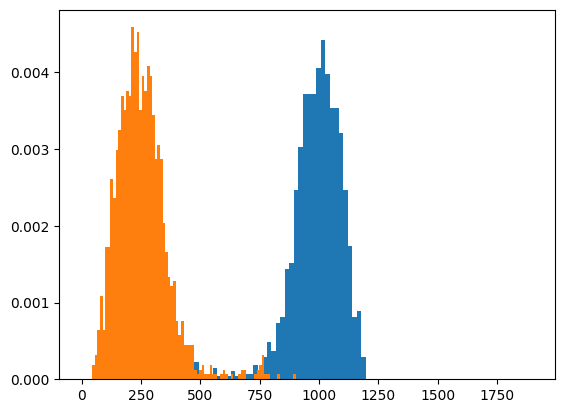

In [15]:
# make a hist plot of the production and the production loss
# let's the zeros from the histview on the distribution 
# we can see a nice pattern emerging around the 1000 for production and around 250 for production loss
plt.hist(brussel_production_wo_nulls,range=(1,1900),bins=100, density = True);
plt.hist(brussel_prod_loss_wo_nulls,range=(1,1100),bins=100, density = True);

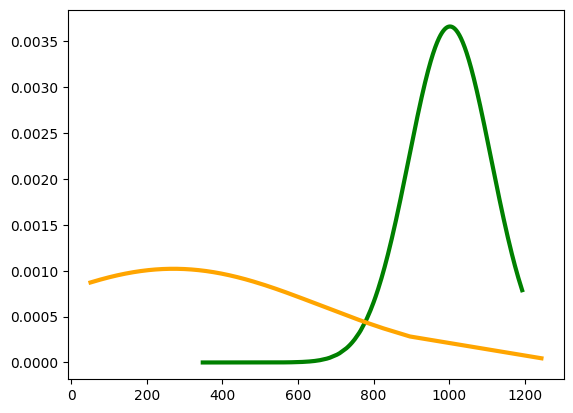

In [16]:
# let's make a nicer plot to see what the distribution looks like or both production and production loss

x_axis = (brussel_production_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()
x_axis_2 = (brussel_prod_loss_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()

# Calculating mean and standard deviation f
mean = statistics.mean(x_axis) 
sd = statistics.stdev(x_axis) 
mdian = statistics.median(x_axis)
mean_2 = statistics.mean(x_axis_2) 
sd_2 = statistics.stdev(x_axis_2) 
mdian_2 = statistics.median(x_axis_2)
plt.plot(x_axis, norm.pdf(x_axis, mdian, sd),color='green', linewidth=3) 
plt.plot(x_axis_2, norm.pdf(x_axis_2, mdian_2, sd_2),color='orange', linewidth=3) 
plt.show()

### detailed production analysis

In [17]:
# let's calculate some values and store them in variables so we can use them in the next few cells
display_production_data_brussels = brussel_production_wo_nulls.sort_values()

production_mean = display_production_data_brussels.mean()
production_median = np.median(display_production_data_brussels)
production_std = statistics.pstdev(display_production_data_brussels)
production_variance = np.var(display_production_data_brussels)
skew = ("negative skew"
        if np.median(display_production_data_brussels)-display_production_data_brussels.mean()>0
        else "positive skew")

813.7119815668203 is the mean
973.5 is the median
Variance: 152568.31911911553
390.59994766911433 is the standard deviation
negative skew


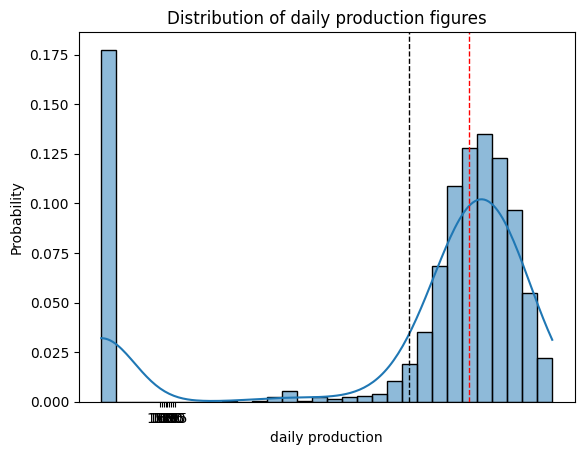

In [18]:
# based on everything above we make a better plot for production data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this

sns.histplot(display_production_data_brussels, bins=30, kde=True, stat='probability')
plt.axvline(display_production_data_brussels.mean(), color='black', linestyle='dashed', linewidth=1)
plt. axvline(np.median(display_production_data_brussels), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production')
plt.ylabel('Probability')
plt.title("Distribution of daily production figures")
plt.xticks(range(155,200,5))
print(f'{production_mean} is the mean')
print(f'{production_median} is the median')
print(f"Variance: {production_variance}")
print(f'{production_std} is the standard deviation')
print(f'{skew}')
plt.show()



In [19]:
# let's use the best fit distribution function to doublecheck the results
best_distribution, best_params = bd.find_best_fit_distribution_continuous(brussel_production_wo_nulls) 

# Print the best-fit distribution and its parameters
print(f"Best-fit distribution: {best_distribution.name}")
print(f"Parameters: {best_params}")

Best-fit distribution: norm
Parameters: (813.7119815668203, 390.59994766911433)


##### simulation for the production

In [ ]:
# try this code cell to make a prediction for n days (without graph)
aantal_dagen=10
voorspellingen_production = bd.simulatie(production_mean, production_std, msr_brussel,aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit de mogelijke productie: ')
for voorspelling in voorspellingen_production:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie voor de volgende {aantal_dagen} dagen is: {totaal}')

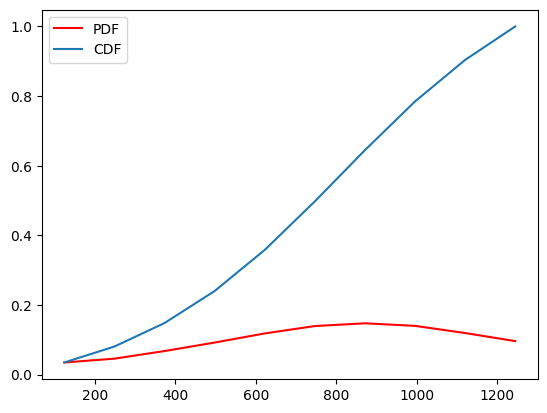

In [21]:
# reuse of production_mean, production_std & msr_brussel we calculated earlier
# pdf = probability distribution function, cdf= cumulative distribution function
cdf_data = bd.simulatie(production_mean, production_std, msr_brussel,10**5)
count, bins_count = np.histogram(cdf_data, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 

Text(0, 0.5, '$p$')

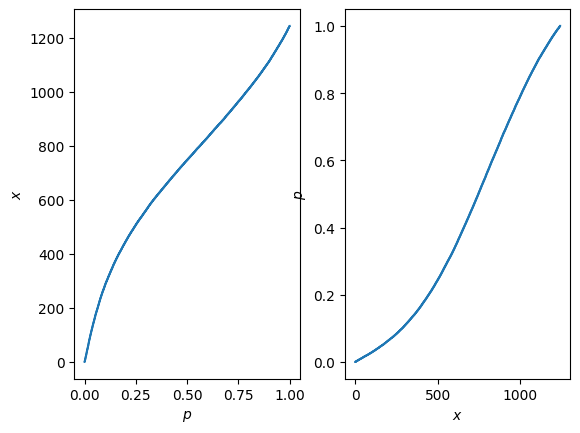

In [22]:
# example found on stack overflow, cumulative distribution function

cdf_data = bd.simulatie(production_mean, production_std, msr_brussel,10**5)
cdf_data_sorted = np.sort(cdf_data)

p = 1. * np.arange(len(cdf_data)) / (len(cdf_data) - 1)

# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(p, cdf_data_sorted)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(cdf_data_sorted, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')

### detailed production loss analysis

In [23]:
# we calculate some values and store them in variables for use in the next few cells
# with the above figures I can recreate a normal distribution with numpy:
data_to_display_prod_loss = brussel_prod_loss_wo_nulls.sort_values()

prod_loss_mean = data_to_display_prod_loss.mean()
prod_loss_median = np.median(data_to_display_prod_loss)
prod_loss_std = statistics.pstdev(data_to_display_prod_loss)
prod_loss_var = np.var(data_to_display_prod_loss)
skew = ("negative skew"
        if np.median(data_to_display_prod_loss)-data_to_display_prod_loss.mean()>0
        else "positive skew")

430.28801843317973 is the mean
270.5 is the median
Variance: 152568.3191191159
390.59994766911433 is the standard deviation
positive skew


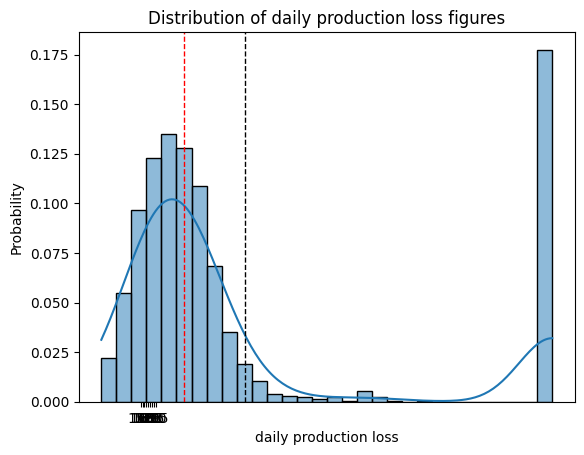

In [24]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this


sns.histplot(data_to_display_prod_loss, bins=30, kde=True, stat='probability')
plt.axvline(data_to_display_prod_loss.mean(), color='black', linestyle='dashed', linewidth=1)
plt. axvline(np.median(data_to_display_prod_loss), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss figures")
plt.xticks(range(155,200,5))
print(f'{prod_loss_mean} is the mean')
print(f'{prod_loss_median} is the median')
print(f"Variance: {prod_loss_var}")
print(f'{prod_loss_std} is the standard deviation')
print(f'{skew}')
plt.show()

##### simulation for the production loss

In [ ]:
aantal_dagen= 7
voorspellingen_production_verlies = bd.simulatie(prod_loss_mean, prod_loss_std, msr_brussel, aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit het mogelijke productie verlies: ')
for voorspelling in voorspellingen_production_verlies:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie verlies voor de volgende {aantal_dagen} dagen is: {totaal}')

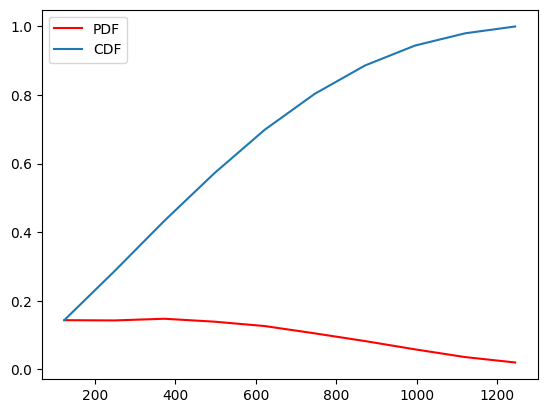

In [31]:
# in this section we reuse the prod_loss_mean and prod_loss_std that we calculated earlier
# pdf = probability distribution function, cdf= cumulative distribution function
cdf_prod_loss_data = bd.simulatie(prod_loss_mean, prod_loss_std, msr_brussel,10**5)
count, bins_count = np.histogram(cdf_prod_loss_data, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf_prod_loss = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
cdf_prod_loss = np.cumsum(pdf_prod_loss) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf_prod_loss, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf_prod_loss, label="CDF") 
plt.legend() 

### details production loss percent

- could be used to make some better prediction on production loss, but not used for now

In [26]:
brussel_prod_loss_perc_wo_nulls  =brussel_data_wo_nulls['prod_loss_perc']

In [27]:
brussel_prod_loss_perc_wo_nulls.describe()

count    1736.000000
mean       34.579493
std        31.413713
min         4.000000
25%        16.000000
50%        22.000000
75%        31.000000
max       100.000000
Name: prod_loss_perc, dtype: float64

In [32]:
# with the above figures I can recreate a normal distribution with numpy:
data_to_display_prod_loss_perc = brussel_prod_loss_perc_wo_nulls.sort_values()
prod_loss_perc_mean = data_to_display_prod_loss_perc.mean()
prod_loss_perc_median = np.median(data_to_display_prod_loss_perc)
prod_loss_perc_std = statistics.pstdev(data_to_display_prod_loss_perc)
prod_loss_perc_var = np.var(data_to_display_prod_loss_perc)
skew_prod_loss_perc = ("negative skew"
                       if np.median(data_to_display_prod_loss_perc)-data_to_display_prod_loss_perc.mean()>0
                       else "positive skew")

34.5794930875576 is the mean
22.0 is the median
Variance: 986.2528974388863
31.404663625628796 is the standard deviation
positive skew


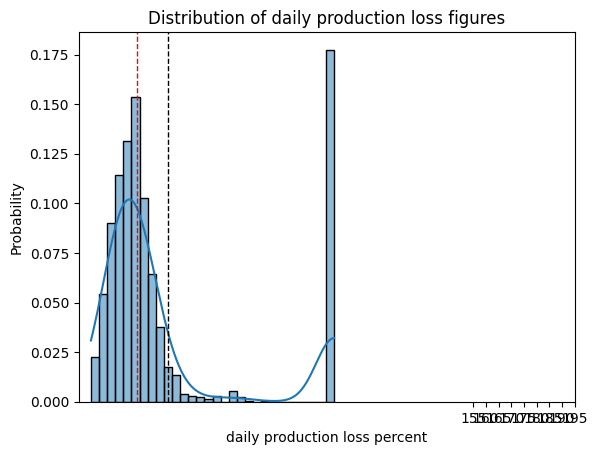

In [33]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this




#numpy_data_prod_loss = np.random.normal(data_mean_prod_loss, data_std_prod_loss)
#numpy_data_prod_loss = (numpy_data_prod_loss - data_mean_prod_loss)/data_std_prod_loss

sns.histplot(data_to_display_prod_loss_perc, bins=30, kde=True, stat='probability')
plt.axvline(data_to_display_prod_loss_perc.mean(), color='black', linestyle='dashed', linewidth=1)
plt. axvline(np.median(data_to_display_prod_loss_perc), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss percent')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss figures")
plt.xticks(range(155,200,5))
print(f'{prod_loss_perc_mean} is the mean')
print(f'{prod_loss_perc_median} is the median')
print(f"Variance: {prod_loss_perc_var}")
print(f'{prod_loss_perc_std} is the standard deviation')
print(f'{skew_prod_loss_perc}')
plt.show()